In [1]:
import torchaudio
import IPython.display as ipd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from model import *
from dataset import *
from const import *
from train import *

In [2]:
class SingleDecoder(nn.Module):
	def __init__(self):
		super(SingleDecoder, self).__init__()
		d_spec = 552
		d_pre = 256
		self.pre_net = nn.Sequential(
			nn.Linear(d_spec, d_pre),
			nn.ReLU(),
			nn.Linear(d_pre, d_pre),
			nn.ReLU()
		)
		self.d_context = 128
		d_lstm_input = self.d_context+d_pre
		self.d_lstm_hidden = 1024
		self.lstm = nn.LSTM(input_size=d_lstm_input, hidden_size=self.d_lstm_hidden, num_layers=2)
		self.lintrans = nn.Linear(self.d_lstm_hidden+self.d_context, d_spec)

	def forward(self, S_pad):
		L = S_pad.shape[0]
		B = S_pad.shape[1]
		h = torch.zeros((2, B, self.d_lstm_hidden), device=device)
		c = torch.zeros((2, B, self.d_lstm_hidden), device=device)
		dummy_context = torch.zeros((B, self.d_context), device=device)
		out_frame_list = []
		for t in range(L):
			if t == 0:
				in_frame = torch.zeros((B, 552), device=device)
			else:
				in_frame = S_pad[t-1, :, :]
			lstm_input = torch.cat([self.pre_net(in_frame), dummy_context], dim=1).unsqueeze(dim=0)
			lstm_output, (h, c) = self.lstm(lstm_input, (h, c))
			out_frame = self.lintrans(torch.cat([lstm_output.squeeze(dim=0), dummy_context], dim=1))
			out_frame_list.append(out_frame)
		S_pred = torch.stack(out_frame_list)
		return S_pred
    


0.058938272 -0.06828102


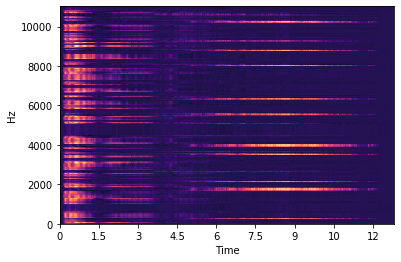

In [43]:
def single_inference():
    net = SingleDecoder()
    net.load_state_dict(torch.load('data/ckpts/latest.sd'))
    loader = get_lj_loader(batch_size=1, limit=1)
    optimizer = torch.optim.Adam(net.parameters())
    n_epochs = 1000
    save_every = 10
    net.to(device)
    with torch.no_grad():
        for batch in loader:
            S_pad, S_lengths, token_pad, token_lengths = batch
            S_pad = S_pad.to(device)
            S_pred = net(S_pad)
    S_pad = S_pad.cpu()
    S_orig = S_pad[:, 0, :].numpy()
    S_pred = S_pred.cpu()
    S_recon = S_pred[:, 0, :].numpy()
    sr = 22050
    librosa.display.specshow(S_recon, sr=sr, x_axis='time', y_axis='linear')
    S_recon = torch.Tensor(S_recon)
    ds = LinSpecDataset(torchaudio.datasets.LJSPEECH('./data'), limit=1)
    wave_recon = ds.spec_to_wav(S_recon)
    wave_recon = wave_recon.squeeze().numpy()
    print(max(wave_recon), min(wave_recon))
    librosa.output.write_wav('data/recon_sample.wav', wave_recon, sr)
    
    
single_inference()

In [ ]:
def griffin_lim_reconstruct_demo():
    dataset = torchaudio.datasets.LJSPEECH('./data')
    wave, sr, _, txt = dataset[0]
    wave = wave[0].numpy().reshape(-1)
    
    n_fft = int(0.05*sr)
    n_mels = 80
    f_min = 125
    f_max = 7600
    S_db = librosa.power_to_db(np.abs(librosa.stft(wave))**2)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear')
    S_pow = librosa.db_to_power(S_db)
    wave_recon = librosa.core.griffinlim(np.sqrt(S_pow))
    librosa.output.write_wav('data/orig_sample.wav', wave, sr)
    librosa.output.write_wav('data/recon_sample.wav', wave_recon, sr)
griffin_lim_reconstruct_demo()

In [45]:
ipd.Audio('data/orig_sample.wav')

In [44]:
ipd.Audio('data/recon_sample.wav')